# Search for available data

Before downloading satellite data it is important to know exactly which data is available and what kind of properties it has. Sentinel Hub offers the [Catalog API](#Sentinel-Hub-Catalog-API) to search collections of data. In AgriDataValue, the components consuming the data from the Climate Change / CAP compliance toolbox, can use the Catalog API responses to know which imagery /indicatore are available in the toolbox. 

In this example tutorial we will show how to use the service to find data collections and then download data from them. 

In [157]:
%matplotlib inline

import datetime as dt

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import CRS, BBox, DataCollection, SHConfig

## Sentinel Hub Catalog API

Catalog API is the main service with the most configurable search options. It supports searches over all available data collections and provides the most information about each item in a collection. The implementation is based on [STAC REST API specifications](https://stacspec.org/).

More information about the service is available in:

- [Documentation](https://docs.sentinel-hub.com/api/latest/api/catalog)
- [API definition](https://docs.sentinel-hub.com/api/latest/reference/#tag/Capabilities)


### Prerequisites

BYOC API requires Sentinel Hub account. Please see [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) how to set up your configuration.

In [158]:
config = SHConfig()

if config.sh_client_id == "" or config.sh_client_secret == "":
    print("Warning! To use Sentinel Hub Catalog API, please provide the credentials (client ID and client secret).")

### Available data collections

In the first, step let's initialize a `SentinelHubCatalog` class and check basic service info:

In [159]:
from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0/core',
  'https://api.stacspec.org/v1.0.0/collections',
  'https://api.stacspec.org/v1.0.0/ogcapi-features',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0/item-search',
  'https://api.stacspec.org/v1.0.0/item-search#fields',
  'https://api.stacspec.org/v1.0.0/item-search#context',
  'https://api.stacspec.org/v1.0.0/item-search#filter',
  'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter',
  'http

Each data collection has its own catalog collection. The default collections are already listed in the info response. Information about all available collections, including user-defined [BYOC](https://docs.sentinel-hub.com/api/latest/data/byoc/) and [batch](https://docs.sentinel-hub.com/api/latest/api/batch/) collections, can be obtained with the next example.

The following code will obtain information about all AgriDataValue collections that are published as BYOC collection. 
Note that these collections are currently stored on a project-internal account, so running this code without appropriate credentials linked to that account will not provide the same response. 

In [160]:
catalog.get_collection(DataCollection.SENTINEL2_L2A)

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'type': 'Collection',
 'id': 'sentinel-2-l2a',
 'title': 'Sentinel 2 L2A',
 'description': 'Sentinel 2 imagery processed to level 2A',
 'sci:citation': 'Modified Copernicus Sentinel data [Year]/Sentinel Hub',
 'license': 'proprietary',
 'providers': [{'name': 'ESA',
   'roles': ['producer'],
   'url': 'https://esa.int/'},
  {'name': 'AWS', 'roles': ['host'], 'url': 'https://aws.amazon.com/'},
  {'name': 'Sinergise',
   'roles': ['processor'],
   'url': 'https://www.sinergise.com/'}],
 'extent': {'spatial': {'bbox': [[-180.0, -56.0, 180.0, 83.0]]},
  'temporal': {'interval': [['2016-11-01T00:00:00Z', None]]}},
 'summaries': {'platform': ['sentinel-2a', 'sentinel-2b'],
  'instrument': ['msi'],
  'constellation': ['sentinel-2'],
  'gsd': [10],
  'eo:cloud_cover': {'minimum': 0, 'maximum': 100},
  'eo:bands': [{'nam

In [161]:
collections = catalog.get_collections()

collections = [collection for collection in collections if collection["title"].startswith("ADV - indicators")]
collections

[{'stac_version': '1.0.0',
  'stac_extensions': [],
  'type': 'Collection',
  'id': 'byoc-088697b8-d145-4ff3-bbb2-87bd94ea0324',
  'title': 'ADV - indicators - tavg',
  'description': 'ADV - indicators - tavg',
  'license': 'proprietary',
  'keywords': ['has_tiles_with_sensing_time'],
  'providers': [],
  'extent': {'spatial': {'bbox': [[-10.474726713,
      34.640273188,
      34.625273287,
      70.040273188]]},
   'temporal': {'interval': [['2024-01-01T00:00:00Z',
      '2024-01-01T00:00:00Z']]}},
  'summaries': {},
  'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/',
    'rel': 'root',
    'type': 'application/json'},
   {'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections/byoc-088697b8-d145-4ff3-bbb2-87bd94ea0324',
    'rel': 'self',
    'type': 'application/json'},
   {'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections',
    'rel': 'parent',
    'type': 'application/json'},
   {'href': 'https://services.s

Information about a single collection can also be obtained with the following method:

In [162]:
collection_ids = [c["id"] for c in collections]

In [163]:
catalog.get_collection(collection_ids[0])

{'stac_version': '1.0.0',
 'stac_extensions': [],
 'type': 'Collection',
 'id': 'byoc-088697b8-d145-4ff3-bbb2-87bd94ea0324',
 'title': 'ADV - indicators - tavg',
 'description': 'ADV - indicators - tavg',
 'license': 'proprietary',
 'keywords': ['has_tiles_with_sensing_time'],
 'providers': [],
 'extent': {'spatial': {'bbox': [[-10.474726713,
     34.640273188,
     34.625273287,
     70.040273188]]},
  'temporal': {'interval': [['2024-01-01T00:00:00Z',
     '2024-01-01T00:00:00Z']]}},
 'summaries': {},
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/',
   'rel': 'root',
   'type': 'application/json'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections/byoc-088697b8-d145-4ff3-bbb2-87bd94ea0324',
   'rel': 'self',
   'type': 'application/json'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'https://services.sentinel-hub.com/api/v1/cat

### Search features in catalog collections

For search we can use `SentinelHubCatalog.search` method. The method always requires a data collection, time interval and a bounding box or a geometry. Additionally, we can define various STAC-based query filters which are described in [documentation](https://docs.sentinel-hub.com/api/latest/api/catalog/) and [API definition](https://docs.sentinel-hub.com/api/latest/reference/#operation/postSearchSTAC).

In [164]:
bbox = BBox(bbox=[-12.128906, 34.885931, 40.781250, 71.965388], crs=CRS.WGS84).transform(CRS.POP_WEB)
time_interval = "2020-12-10", "2024-02-01"

search_iterator = catalog.search(
    collection_ids[0],
    bbox=bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime", "eo:bands"], "exclude": []},
)

results = list(search_iterator)
results

[{'id': '112a388d-1ac3-454a-bae8-9afe14ae47fe',
  'properties': {'datetime': '2024-01-01T00:00:00Z'}}]

In [165]:
catalog.get_feature(collection_ids[0], "112a388d-1ac3-454a-bae8-9afe14ae47fe")

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
 'id': '112a388d-1ac3-454a-bae8-9afe14ae47fe',
 'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
  'coordinates': [[[-10.474726712999939, 34.640273188000045],
    [34.62527328700006, 34.640273188000045],
    [34.62527328700006, 70.04027318800004],
    [-10.474726712999939, 70.04027318800004],
    [-10.474726712999939, 34.640273188000045]]]},
 'bbox': [-10.474726712999939,
  34.640273188000045,
  34.62527328700006,
  70.04027318800004],
 'properties': {'datetime': '2024-01-01T00:00:00Z',
  'proj:epsg': 84,
  'proj:bbox': [-10.474726712999939,
   34.640273188000045,
   34.62527328700006,
   70.04027318800004],
  'proj:geometry': {'type': 'Polygon',
   'crs': {'type': 'name',
    'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
   'coordinates': [[[-10.474726712999939, 34.640273188000

### Combine Catalog API with Process API

With Catalog API we were able to get information about available tiles for a given bounding box and time interval. Let's see how we can use this information with [Process API](./process_request.ipynb) to download data for all acquisitions.

We can see that many timestamps differ only for a few seconds. That is because they are from tiles in the same orbit acquisition. Because of that, we want to join them together in a single timestamp.

In [166]:
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, filter_times

time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2024, 1, 1, 0, 0, tzinfo=tzutc())]

Next, we create a Process API request for each acquisition:

In [167]:
indicator_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["tavg_ref_1995_2015"]
            }],
            output: {
                bands: 1, sampleType: SampleType.FLOAT32
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.tavg_ref_1995_2015];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=indicator_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(collection_ids[0].split("byoc-")[1]),
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=(10000, 10000),
        config=config,
    )
    process_requests.append(request)

In order to efficiently download data for all requests in parallel, we extract download information and pass it to a download client.

In [168]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 26.5 ms, sys: 10.6 ms, total: 37.1 ms
Wall time: 1.12 s


(759, 589)

In [169]:
indicator = np.where(data[0] < 0.1, np.nan, data[0])

Text(0.5, 1.0, 'Average Temperature (Historical 1995-2015)')

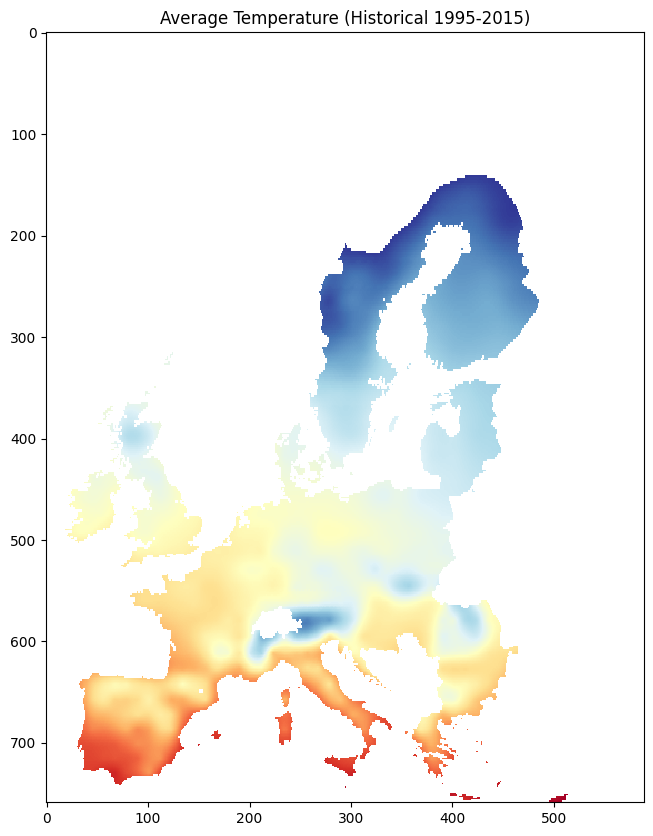

In [173]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(indicator, vmin=0, vmax=20, cmap="RdYlBu_r")
ax.set_title("Average Temperature (Historical 1995-2015)")